# Model training

Data type: 
- explanatory variable: both categorical and numerical
- response variable: numerical

Possible model choice
- xgboost
- deep learning model(hash the categorical variables to numeric)
- 

In [1]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## data splitting

In [2]:
train_df = pd.read_csv("../data/train_exp.csv")

In [3]:
X_df = train_df.drop(['id',"scalar_coupling_constant","molecule_name",'atom_index_0','atom_index_1'],axis=1)
y_df = train_df["scalar_coupling_constant"]

In [4]:
def label_func():
    for i in ['type','atom_0','atom_1']:
        lb_make = LabelEncoder()
        X_df[i] = lb_make.fit_transform(X_df[i])
label_func()

In [5]:
train_X, val_X, train_y, val_y = train_test_split(X_df,y_df, test_size = 0.2, random_state=1,stratify=X_df.type)
print(train_X.shape)
print(val_X.shape)

(3726517, 13)
(931630, 13)


## deep learning model

In [6]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_X.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(96, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [7]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

W0722 22:44:53.421645 140734723327808 deprecation_wrapper.py:119] From /home/cesare/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0722 22:44:53.424045 140734723327808 deprecation_wrapper.py:119] From /home/cesare/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0722 22:44:53.492744 140734723327808 deprecation_wrapper.py:119] From /home/cesare/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [8]:
## best epochs = 80 by now
num_epochs = 40
model = build_model()
history = model.fit(train_X, train_y,
                    validation_data=(val_X, val_y),
                    epochs=num_epochs, batch_size=500, verbose=1)
mae_history = history.history['val_mean_absolute_error']

W0722 22:44:53.517158 140734723327808 deprecation_wrapper.py:119] From /home/cesare/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 22:44:53.524878 140734723327808 deprecation_wrapper.py:119] From /home/cesare/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 22:44:53.676393 140734723327808 deprecation_wrapper.py:119] From /home/cesare/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Train on 3726517 samples, validate on 931630 samples
Epoch 1/40
3726517/3726517 [==============================] - 53s 14us/step - loss: 65.5776 - mean_absolute_error: 4.2911 - val_loss: 49.2998 - val_mean_absolute_error: 3.9517
Epoch 2/40
3726517/3726517 [==============================] - 48s 13us/step - loss: 46.1767 - mean_absolute_error: 3.5867 - val_loss: 48.3604 - val_mean_absolute_error: 3.5508
Epoch 3/40
3726517/3726517 [==============================] - 46s 12us/step - loss: 42.5414 - mean_absolute_error: 3.4459 - val_loss: 42.2593 - val_mean_absolute_error: 3.4734
Epoch 4/40
3726517/3726517 [==============================] - 44s 12us/step - loss: 39.9883 - mean_absolute_error: 3.3465 - val_loss: 45.9865 - val_mean_absolute_error: 3.3850
Epoch 5/40
3726517/3726517 [==============================] - 48s 13us/step - loss: 38.5503 - mean_absolute_error: 3.2904 - val_loss: 39.2170 - val_mean_absolute_error: 3.5815
Epoch 6/40
3726517/3726517 [==============================] - 50s 1

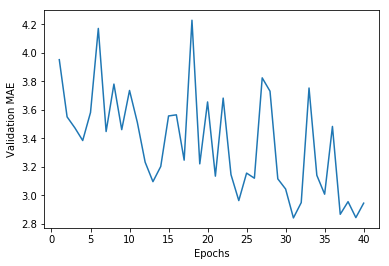

In [9]:
plt.plot(range(1, len(mae_history) + 1), mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## model evaluation

In [10]:
def score_per_type(x):
    return np.log(np.mean(np.abs(x['pred_coupling_constant'].values - x['scalar_coupling_constant'].values)))

def evaluation_score(results_df):
    results = results_df[['scalar_coupling_constant','pred_coupling_constant','type']].groupby("type")
    return np.mean(results.apply(score_per_type))

In [11]:
val_X['pred_coupling_constant'] = model.predict(val_X)
val_X['scalar_coupling_constant'] = val_y
evaluation_score(val_X)

/home/cesare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/cesare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.9151155033065926

## Final result check

In [12]:
test_df = pd.read_csv("../data/test_exp.csv")
test_df['id'] = test_df['id'].astype(int)
X_df = test_df.drop(['id',"molecule_name",'atom_index_0','atom_index_1'],axis=1)
label_func()
test_df["scalar_coupling_constant"] = model.predict(X_df)

In [13]:
test_df[["id","scalar_coupling_constant"]].to_csv("../data/submission2.csv",index=False)